# Premiers Tests

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk import WordNetLemmatizer
from nltk import word_tokenize
import spicy
import seaborn as sns

In [2]:
from tqdm.notebook import tqdm_notebook

In [3]:
with open('data/s/train_s.jsonl', 'r') as f:
  a = list(f)

data_s =[]
for element in a:
  data_s.append(json.loads(element))

data_s = pd.DataFrame(data_s)

In [4]:
with open('data/l/train_l.jsonl', 'r') as f:
  a = list(f)

data_l =[]
for element in a:
  data_l.append(json.loads(element))

data_l = pd.DataFrame(data_l)

In [5]:
with open('data/xl/train_xl.jsonl', 'r') as f:
  a = list(f)

data_xl =[]
for element in a:
  data_xl.append(json.loads(element))

data_xl = pd.DataFrame(data_xl)

In [6]:
data_s.head(3)

,qID,sentence,option1,option2,answer
0,3QHITW7OYO7Q6B6ISU2UMJB84ZLAQE-2,Ian volunteered to eat Dennis's menudo after a...,Ian,Dennis,2
1,3QHITW7OYO7Q6B6ISU2UMJB84ZLAQE-1,Ian volunteered to eat Dennis's menudo after a...,Ian,Dennis,1
2,3XWUWJ18TLO2DDRXF83QWLKRJ29UU4-1,"He never comes to my home, but I always go to ...",home,house,1


### $1^{ère}$ métrique : Clustering KMeans sur matrice de TDIDF

Obtention d'une matrice de TF-IDF puis clustering avec KMeans cette matrice (2 cas : lemmatisées ou non)
Remarque sur les clusters obtenus:
- Ils ne sont pas très pertinents (pas logique sémantique dans le cluster)
- Ils ne sont pas impactés par la lemmatisation

Remarque sur les plots de distortions, inerties :
- Clusters optimaux pour envrion $n_{clusters} = 300$ (résultat logique car on retrouve approximativement 320 schéma "soeur" dans la base de données)

In [4]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(data_s['sentence'])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)

c:\users\marti\work\lattice-internship\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [138]:
clustering = KMeans(n_clusters=200)
clusters = clustering.fit_predict(df)
data_s['Cluster'] = clusters

In [145]:
data_s[data_s['cluster']==0]['sentence']

398    Have you ever been on  a nature walk Samantha ...
399    Have you ever been on  a nature walk Samantha ...
Name: sentence, dtype: object

In [17]:
def sentence_lemmatizer(sentence):
  WNL = WordNetLemmatizer()
  lemmatized=[]
  for word in word_tokenize(sentence):
    if word.isalpha():
      lemms = [WNL.lemmatize(word,pos=f'{param}') for param in ['v','n','a','r','s']]
      ind = np.argmin([len(lemm) for lemm in lemms])
      lemmatized.append(lemms[ind])
  return ' '.join(lemmatized)

In [20]:
data_s['lemmatized_sentence'] = data_s['sentence'].apply(sentence_lemmatizer)

In [142]:
data_s.head(2)

,qID,sentence,option1,option2,answer,cluster,cos,dist,lemmatized_sentence,cluster2,sentence_bow,Cluster
0,3QHITW7OYO7Q6B6ISU2UMJB84ZLAQE-2,Ian volunteered to eat Dennis's menudo after a...,Ian,Dennis,2,171,0.000000,0.000000,Ian volunteer to eat Dennis menudo after alrea...,0,"[ian, volunteer, eat, dennis, menudo, already,...",152
1,3QHITW7OYO7Q6B6ISU2UMJB84ZLAQE-1,Ian volunteered to eat Dennis's menudo after a...,Ian,Dennis,1,171,0.950838,0.443452,Ian volunteer to eat Dennis menudo after alrea...,0,"[ian, volunteer, eat, dennis, menudo, already,...",152


In [141]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(data_s['lemmatized_sentence'])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df2 = pd.DataFrame(denselist,columns=feature_names)

c:\users\marti\work\lattice-internship\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [143]:
clustering = KMeans(200)
clusters = clustering.fit_predict(df2)
data_s['cluster2']= clusters

In [146]:
data_s[data_s['cluster2']==0]['sentence']

396    It took Jerry longer to shampoo his hair than ...
397    It took Jerry longer to shampoo his hair than ...
448    Jason's leg was more sore than his arm was bec...
449    Jason's leg was more sore than his arm was alt...
Name: sentence, dtype: object

In [45]:
distortions = []
inertias = []
from scipy.spatial.distance import cdist
K = range(1, 500)

for k in tqdm_notebook(K,desc = 'Progress Bar'):
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(df2)
    kmeanModel.fit(df2)

    distortions.append(sum(np.min(cdist(df2, kmeanModel.cluster_centers_,'euclidean'), axis=1)) / df2.shape[0])
    inertias.append(kmeanModel.inertia_)

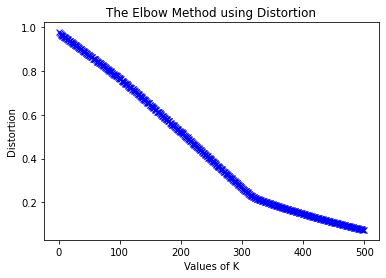

In [46]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

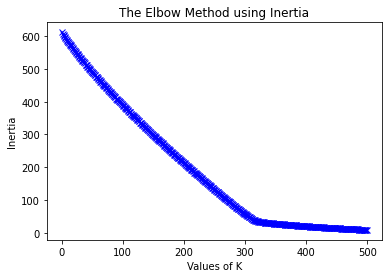

In [47]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

Enregistrement de la matrice de tfidf pour des utilisations futures

In [13]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(data_xl['sentence'])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
df_xl = pd.DataFrame(dense, columns=feature_names)

df_xl.to_csv('data/tf-idf/tf-idf-matrix.csv')

c:\users\marti\work\lattice-internship\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [22]:
def lemmatized_for_tfidf(sentence):
    return ' '.join(topic_modeling_preprocessing(sentence))

In [23]:
data_xl['lemmatized-sentence'] = [lemmatized_for_tfidf(sentence) for sentence in data_xl['sentence']]

In [24]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(data_xl['lemmatized-sentence'])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
df_xl = pd.DataFrame(dense, columns=feature_names)

df_xl.to_csv('data/tf-idf/tf-idf-matrix-lemmatized.csv')

c:\users\marti\work\lattice-internship\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### $2^{nd}$ métrique : Topic Modeling

La LDA sépare les phrases "soeurs" $\rightarrow$ il distingue donc la différence de sens entre ces phrases, malgré leur proximité lexicale

Note sur LDA : il s'appuie sur un algorithme de Gibbs Sampling (pas un algo de clustering)

In [20]:
from nltk.corpus import stopwords
import gensim
from gensim.corpora import Dictionary

In [21]:
def topic_modeling_preprocessing(sentence):
    WNL = WordNetLemmatizer()
    bow = [word.lower() for word in word_tokenize(sentence) if not word in stopwords.words('english')]
    preprocessed_bow = []
    for word in bow:
        if word.isalpha():
            lemms = [WNL.lemmatize(word,pos=f'{param}') for param in ['v','n','a','r','s']]
            ind = np.argmin([len(lemm) for lemm in lemms])
            preprocessed_bow.append(lemms[ind])
    return preprocessed_bow

In [88]:
data_s['sentence_bow'] = [topic_modeling_preprocessing(sentence) for sentence in list(data_s['sentence'])]

In [110]:
dictionary = Dictionary(list(data_s['sentence_bow']))
bow_corpus = [dictionary.doc2bow(doc) for doc in list(data_s['sentence_bow'])]

n_topics= 90
lda = gensim.models.LdaMulticore(bow_corpus,num_topics=n_topics,id2word=dictionary)

In [115]:
ex_list = [element[0] for element in lda.get_topic_terms(15)]
for element in ex_list:
    if element <= 640:
        print(data_s.iloc[element]['sentence'])
        print('----------')

Brian had a large collection of coins that Kevin really admired, so _ offered him some duplicates.
----------
The employees threw a party and drank so much alcohol that they could not go into work the next day. The _ was loud.
----------
To overcome behavioural bias, we need to focus more on changing the conscious actions instead of the unconscious actions because the _ actions are voluntary.
----------
Jessica took off the gloves and gave them to Katrina because _ 's hands were cold.
----------
Chess is bad for the body but great for the brain, as thinking is useless for the _ to develop.
----------
The experience was totally unforgettable for Betty but not Samantha because _ had anticipated it for months.
----------
Ben had to either stop eating chocolates or nuts. He chose to stop eating the _ because they were savory.
----------
The couple drank wine out of glasses instead of mugs, because the _ were clean.
----------


In [ ]:
dictionary = Dictionary(list(data_s['s']))

In [119]:
from gensim.models import CoherenceModel
# Compute Coherence Score
list_coherence = []
for i in tqdm_notebook(range(1,50)):
    if i%5 == 0:
        print(i)
    lda_model = lda = gensim.models.LdaMulticore(bow_corpus,
                                                 num_topics=i,
                                                 id2word=dictionary)
    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=list(data_s['sentence_bow']),
                                         dictionary=dictionary,
                                         coherence='c_v')
    list_coherence.append(coherence_model_lda.get_coherence())

5
10
15
20
25
30
35
40
45


In [121]:
for i in tqdm_notebook(range(51,70)):
    if i%5 == 0:
        print(i)
    lda_model = lda = gensim.models.LdaMulticore(bow_corpus,
                                                 num_topics=i,
                                                 id2word=dictionary)
    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=list(data_s['sentence_bow']),
                                         dictionary=dictionary,
                                         coherence='c_v')
    list_coherence.append(coherence_model_lda.get_coherence())

55
60
65


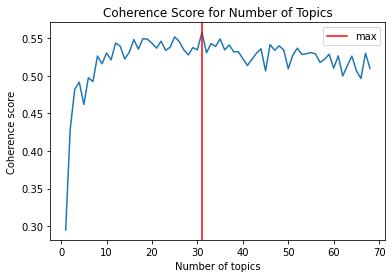

In [131]:
plt.plot(range(1,69),list_coherence)
plt.axvline(31,color='red',label='max')
plt.xlabel('Number of topics')
plt.ylabel('Coherence score')
plt.title('Coherence Score for Number of Topics')
plt.legend()

Exemple de schema dans un topic pour $n_{topic}^{optimal}$

In [133]:
#opti lda
lda = gensim.models.LdaMulticore(bow_corpus,num_topics=31,id2word=dictionary)

In [148]:
ex_list = [element[0] for element in lda.get_topic_terms(15)]
for element in ex_list:
    if element <= 640:
        print(data_s.iloc[element]['sentence'])
        print('- - - - -')

The sushi rotted on the counter unless it was put in the cooler, as the _ exposed it to contamination.
- - - - -
Victoria was disgusted because of the odor of Sarah, and _ did not want to be around them.
- - - - -
Donald was richer than Leslie was because companies had found oil on the property of _ .
- - - - -
Once in Poland, Dennis enjoyed the trip more than Jason because _ had a deeper understanding of the Polish language.
- - - - -
I couldn't control the moisture like I controlled the rain, because the _ was coming in everywhere.
- - - - -
Emptying the litter box was a dreaded chore for Adam while Lawrence didn't mind doing it. _ never tried to get someone else to handle it.
- - - - -
To overcome behavioural bias, we need to focus more on changing the conscious actions instead of the unconscious actions because the _ actions are voluntary.
- - - - -
I installed a new bird house outside above the ground, but had to prop it up higher away from my cat since the _ was too low.
- - - - 

Idée pour l'établissement de la métrique basée sur cette méthode :
- réaliser le topic modeling sur la base de test pour $n_{topic}^{optimal}$ , fine-tuner ce modèle
- regarder la distribution de proba de l'appartenance de chaque document du training set aux différents topics du test set
- prendre, pour chaque document, la valeur de la proba d'appartenance maximale en guise de mesure ($\rightarrow$ plus un doc est sûr d'appartenir à un topic, plus il est précis et donc proche des phrases du cluster de ce topic)
- ordonner les docs du set d'entrainement en ordre croissant sur cette mesure, puis entrainer sur des buckets

### $3^{ème}$ métrique : Mesures usuelles appliquées à des Vectorizers (sklearn & BERT/Transformers)

#### BERT/ Transformers

Résultats plus interessant que TFIDF : l'algo ne se limite pas à un travail de fréquence sur les mots. Le modèle intègre le sens de chaque mot et le contexte

In [7]:
from sentence_transformers import SentenceTransformer

In [8]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [9]:
sentence_embeddings = model.encode(list(data_s['sentence']))

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

In [11]:
scores = np.zeros((sentence_embeddings.shape[0],sentence_embeddings.shape[0]))
for i in tqdm_notebook(range(sentence_embeddings.shape[0])):
    scores[i:] = cosine_similarity([sentence_embeddings[i]],sentence_embeddings)[0]

  0%|          | 0/640 [00:00<?, ?it/s]

In [12]:
pd.DataFrame(scores).reset_index()[['index',0]].sort_values(0,ascending=False)

,index,0
0,0,1.000000
1,1,0.863690
599,599,0.791758
152,152,0.771429
146,146,0.764655
...,...,...
398,398,0.159499
440,440,0.125940
441,441,0.123023
8,8,0.077282


c:\users\marti\work\lattice-internship\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution des cosine_similarity pour la phrase 0')

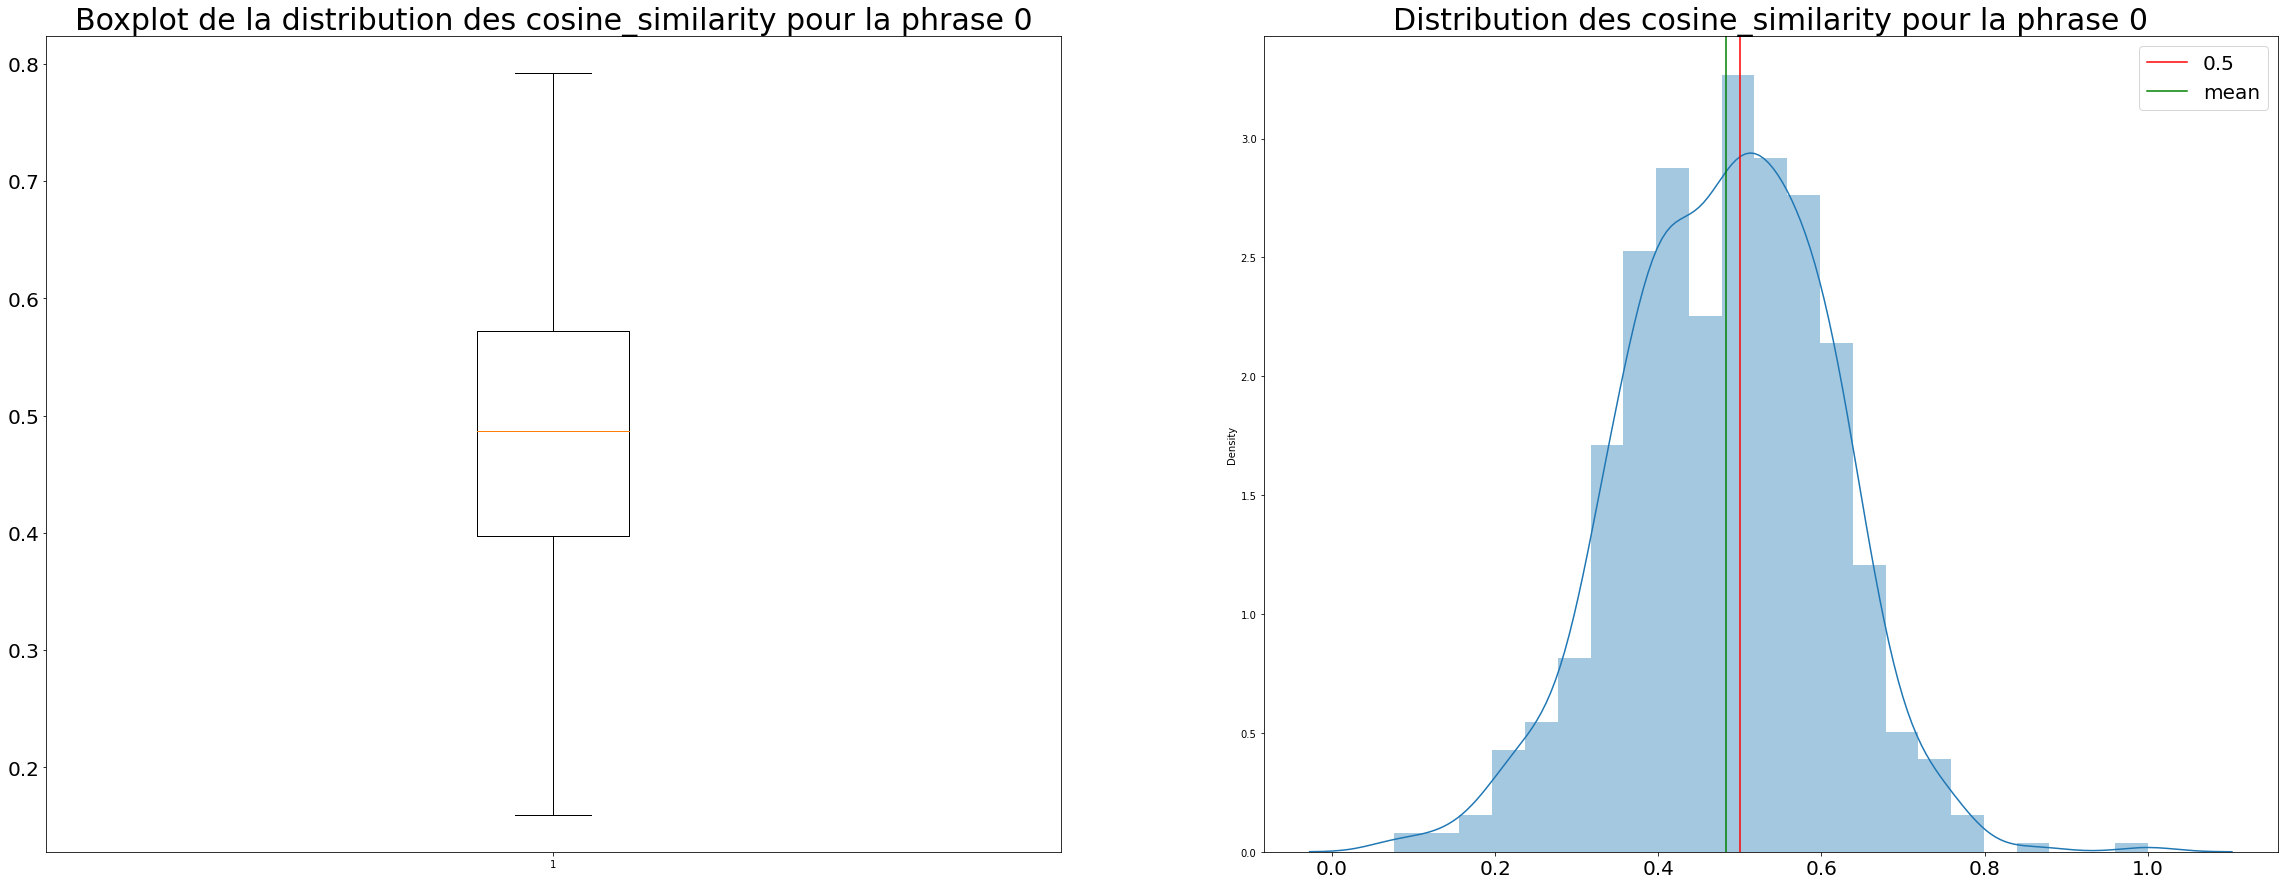

In [36]:
plt.figure(figsize=(40,15))
plt.subplot(1,2,1)
plt.boxplot(list(pd.DataFrame(scores)[0]),showfliers=False)
plt.title('Boxplot de la distribution des cosine_similarity pour la phrase 0',fontsize = 30)
plt.tick_params(axis = 'y', labelsize = 20)
plt.subplot(1,2,2)
sns.distplot(list(pd.DataFrame(scores)[0]))
plt.axvline(0.5,color='red',label='0.5')
plt.axvline(np.mean(list(pd.DataFrame(scores)[0])),color = 'green',label='mean')
plt.tick_params(axis = 'x', labelsize = 20)
plt.legend(fontsize=20)
plt.title('Distribution des cosine_similarity pour la phrase 0',fontsize = 30)

In [38]:
df_scores = pd.DataFrame(scores)
df_scores.mean()

0      0.482872
1      0.413523
2      0.443950
3      0.417030
4      0.442215
         ...   
635    0.444023
636    0.426617
637    0.412838
638    0.348043
639    0.376938
Length: 640, dtype: float64

c:\users\marti\work\lattice-internship\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution des moyennes des cosine_similarity de data_s')

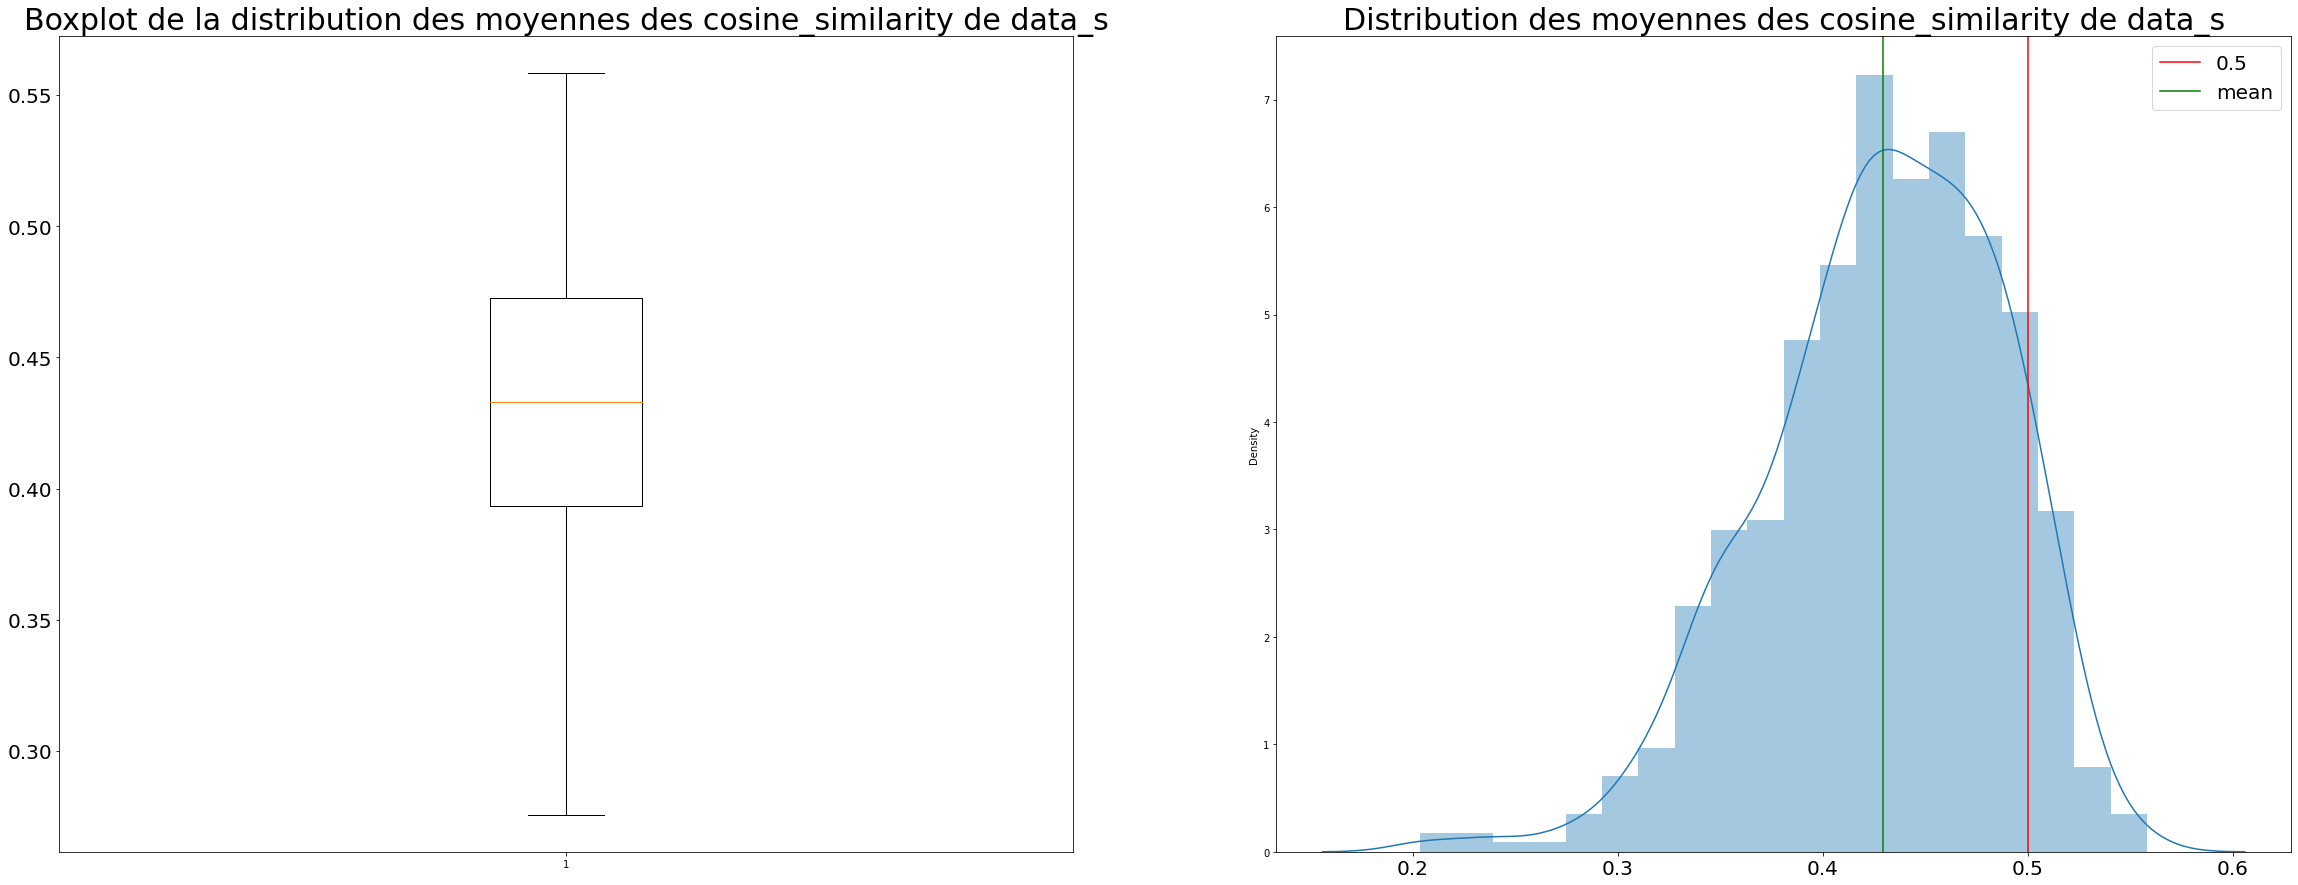

In [40]:
plt.figure(figsize=(40,15))
plt.subplot(1,2,1)
plt.boxplot(list(df_scores.mean()),showfliers=False)
plt.title('Boxplot de la distribution des moyennes des cosine_similarity de data_s',fontsize = 30)
plt.tick_params(axis = 'y', labelsize = 20)
plt.subplot(1,2,2)
sns.distplot(list(df_scores.mean()))
plt.axvline(0.5,color='red',label='0.5')
plt.axvline(np.mean(list(df_scores.mean())),color = 'green',label='mean')
plt.tick_params(axis = 'x', labelsize = 20)
plt.legend(fontsize=20)
plt.title('Distribution des moyennes des cosine_similarity de data_s',fontsize = 30)

In [13]:
print(data_s.iloc[0]['sentence'])
print('---------------')
for i in [1,599,152,146,555,554,153,179]:
    print(data_s.iloc[i]['sentence'])

Ian volunteered to eat Dennis's menudo after already having a bowl because _ despised eating intestine.
---------------
Ian volunteered to eat Dennis's menudo after already having a bowl because _ enjoyed eating intestine.
Dina fed her children yogurt instead of ice cream because she thought that the _ was unhealthy.
Ben had to either stop eating chocolates or nuts. He chose to stop eating the _ because they were savory.
The sushi rotted on the counter unless it was put in the cooler, as the _ exposed it to contamination.
Katrina loves the taste of lettuce but Angela doesn't. _ ordered a big steak for dinner.
Katrina loves the taste of lettuce but Angela doesn't. _ ordered a big salad for dinner.
Ben had to either stop eating chocolates or nuts. He chose to stop eating the _ because they were sweet.
William wanted an egg for breakfast, but Kevin ate the last one, so _ had to eat cereal.


In [44]:
sentence_embeddings_xl = model.encode(list(data_xl['sentence']))
scores_xl = np.zeros((sentence_embeddings_xl.shape[0],sentence_embeddings_xl.shape[0]))
for i in tqdm_notebook(range(sentence_embeddings_xl.shape[0])):
    scores_xl[i:] = cosine_similarity([sentence_embeddings_xl[i]],sentence_embeddings_xl)[0]

MemoryError: Unable to allocate 12.2 GiB for an array with shape (40398, 40398) and data type float64

In [ ]:
sentence_embeddings_xl = model.encode(list(data_xl['sentence']))

In [ ]:
sentence_embeddings_xl = sentence_embeddings_xl.to_numpy()
list_scores = []
for i in tqdm_notebook(range(sentence_embeddings_xl.shape[0])):
    list_scores.append(
        cosine_similarity([sentence_embeddings_xl[i]],sentence_embeddings_xl)[0]
    )

In [ ]:
scores_xl = pd.DataFrame(scores_xl)
scores_xl.to_csv('data/bert/similarity_bert_encoding.csv')

In [45]:
sentence_embeddings_xl = pd.DataFrame(sentence_embeddings_xl)
sentence_embeddings_xl.to_csv('data/bert/sentences_bert_768_encoding')

In [ ]:
df_scores = pd.DataFrame(scores)
plt.boxplot(list(df_scores[0]),
            showfliers=False)